# Loudoun County Growth Study

## Import Libraries

In [13]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Set seaborn style
sns.set_theme(style="whitegrid")

# Define data directory
data_dir = r"C:\Users\AKKem\OneDrive\Desktop\Data Analysis Modules\Projects\Loudoun_Growth_Study\data"



In [14]:
# File paths
files = {
    "population_housing": "2020_decennial_population_housing.csv",
    "bls_data": "Combined_BLS_Data.csv",
    "census_data": "Combined_Census_Data.csv",
    "demographics_data": "Combined_Demographics_Data.csv",
    "gdp_data": "Combined_GDP_Data.csv",
    "cbp_data": "CB2200CBP.csv",
    "income_data": "Combined_B19013.csv",
    "housing_value_data": "Combined_B25077.csv",
    "housing_characteristics": "Combined_DP04.csv",
    "demographics_estimates": "Combined_DP05.csv",
    "occupation_earnings": "Combined_S2401.csv",
    "industry_occupation": "Combined_S2403.csv"
}

# Load all datasets into a dictionary of DataFrames
datasets = {name: pd.read_csv(os.path.join(data_dir, file)) for name, file in files.items()}

# Display loaded datasets
for name, df in datasets.items():
    print(f"{name}: {df.shape}")
    print(df.head(), "\n")


population_housing: (174, 3)
         Label (Grouping) Loudoun County, Virginia!!Count  \
0             SEX AND AGE                             NaN   
1        Total population                         420,959   
2           Under 5 years                          27,065   
3            5 to 9 years                          33,089   
4          10 to 14 years                          36,363   

  Loudoun County, Virginia!!Percent  
0                               NaN  
1                           100.00%  
2                             6.40%  
3                             7.90%  
4                             8.60%   

bls_data: (875, 17)
   area_fips  own_code  Industry Code  agglvl_code  size_code  year qtr  \
0      48113         0             10           70          0  2020   A   
1      48113         1             10           71          0  2020   A   
2      48113         1            101           72          0  2020   A   
3      48113         1            102           72    

In [15]:
# Check each file individually
for name, file in files.items():
    try:
        df = pd.read_csv(os.path.join(data_dir, file))
        print(f"{name}: Loaded successfully with shape {df.shape}")
    except Exception as e:
        print(f"{name}: Failed to load. Error: {e}")


population_housing: Loaded successfully with shape (174, 3)
bls_data: Loaded successfully with shape (875, 17)
census_data: Loaded successfully with shape (1690, 23)
demographics_data: Loaded successfully with shape (445, 12)
gdp_data: Loaded successfully with shape (154, 7)
cbp_data: Loaded successfully with shape (1198, 7)
income_data: Loaded successfully with shape (4, 8)
housing_value_data: Loaded successfully with shape (12, 8)
housing_characteristics: Loaded successfully with shape (635, 8)
demographics_estimates: Loaded successfully with shape (375, 8)
occupation_earnings: Loaded successfully with shape (143, 43)
industry_occupation: Loaded successfully with shape (107, 43)


In [16]:
# Cleaning example for one dataset - repeat for others as needed
def clean_data(df):
    # Standardize column names
    df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")
    
    # Handle missing values
    df = df.dropna()  # Or use df.fillna(value) for specific replacements
    
    # Ensure numeric columns are properly typed
    for col in df.select_dtypes(include='object').columns:
        try:
            df[col] = pd.to_numeric(df[col], errors='coerce')
        except:
            pass
    return df

# Apply cleaning to all datasets
datasets_cleaned = {name: clean_data(df) for name, df in datasets.items()}

# Example: Check a cleaned dataset
datasets_cleaned["bls_data"].info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 875 entries, 0 to 874
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   area_fips                       875 non-null    int64  
 1   own_code                        875 non-null    int64  
 2   industry_code                   875 non-null    int64  
 3   agglvl_code                     875 non-null    int64  
 4   size_code                       875 non-null    int64  
 5   year                            875 non-null    int64  
 6   qtr                             0 non-null      float64
 7   annual_avg_estabs               875 non-null    int64  
 8   annual_avg_emplvl               875 non-null    int64  
 9   total_annual_wages              769 non-null    float64
 10  taxable_annual_wages            428 non-null    float64
 11  annual_contributions            875 non-null    int64  
 12  annual_avg_wkly_wage            769 

C:\Users\AKKem\AppData\Local\Temp\ipykernel_32024\19008510.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = pd.to_numeric(df[col], errors='coerce')
C:\Users\AKKem\AppData\Local\Temp\ipykernel_32024\19008510.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = pd.to_numeric(df[col], errors='coerce')
C:\Users\AKKem\AppData\Local\Temp\ipykernel_32024\19008510.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

# Data Cleaning and Preparation

In [17]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt

# Load the CBP data
cbp_data = datasets["cbp_data"]

# Display the first few rows and column names to understand structure
print(cbp_data.columns)

# Identify the correct columns
geo_column = "Geographic Area Name (NAME)"  # Replace with the actual column name for location
naics_column = "2017 NAICS code (NAICS2017)"  # Replace with the actual column name for NAICS codes
establishments_column = "Number of establishments (ESTAB)"  # Replace with the actual column name for establishments

# Ensure these columns exist
if geo_column in cbp_data.columns and naics_column in cbp_data.columns and establishments_column in cbp_data.columns:
    # Filter for Loudoun County
    loudoun_businesses = cbp_data[cbp_data[geo_column].str.contains("Loudoun County", na=False)]

    # Convert the establishments column to numeric
    loudoun_businesses[establishments_column] = pd.to_numeric(
        loudoun_businesses[establishments_column].str.replace(",", ""), errors='coerce'
    )

    # Group by NAICS code and sum establishments
    industry_businesses = (
        loudoun_businesses.groupby(naics_column)[establishments_column].sum().sort_values(ascending=False)
    )

    # Plot the top industries
    plt.figure(figsize=(10, 6))
    industry_businesses.head(10).plot(kind="bar", color="skyblue")
    plt.title("Top Industries by Number of Businesses in Loudoun County")
    plt.xlabel("NAICS Code")
    plt.ylabel("Number of Establishments")
    plt.xticks(rotation=45)
    plt.show()
else:
    print("Required columns are not present in the dataset.")



Index(['geographic_area_name_(name)', '2017_naics_code_(naics2017)',
       'year_(year)', 'number_of_establishments_(estab)',
       'annual_payroll_($1,000)_(payann)',
       'first-quarter_payroll_($1,000)_(payqtr1)',
       'number_of_employees_(emp)'],
      dtype='object')
Required columns are not present in the dataset.


Columns in the dataset: Index(['geographic_area_name_(name)', '2017_naics_code_(naics2017)',
       'year_(year)', 'number_of_establishments_(estab)',
       'annual_payroll_($1,000)_(payann)',
       'first-quarter_payroll_($1,000)_(payqtr1)',
       'number_of_employees_(emp)'],
      dtype='object')
Identified Columns - Geographic: geographic_area_name_(name), NAICS: 2017_naics_code_(naics2017), Establishments: number_of_establishments_(estab)


C:\Users\AKKem\AppData\Local\Temp\ipykernel_32024\191637466.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loudoun_businesses[establishments_column] = pd.to_numeric(


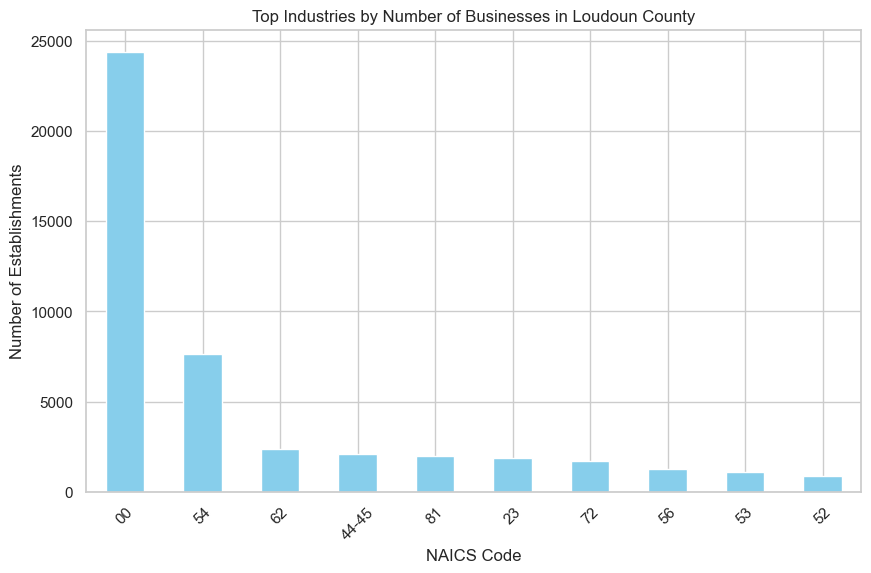

In [18]:
## Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt

# Load the CBP data
cbp_data = datasets["cbp_data"]

# Inspect the columns to identify the one for geographic areas
print("Columns in the dataset:", cbp_data.columns)

# Dynamically identify relevant columns
geo_column = None
naics_column = None
establishments_column = None

for col in cbp_data.columns:
    if "geographic" in col.lower():
        geo_column = col
    if "naics" in col.lower():
        naics_column = col
    if "establishments" in col.lower():
        establishments_column = col

# Check if required columns are identified
if not geo_column or not naics_column or not establishments_column:
    raise ValueError("Required columns (geographic, NAICS, establishments) not found in dataset.")

print(f"Identified Columns - Geographic: {geo_column}, NAICS: {naics_column}, Establishments: {establishments_column}")

# Filter for Loudoun County
loudoun_businesses = cbp_data[cbp_data[geo_column].str.contains("Loudoun County", na=False)]

# Convert the establishments column to numeric
loudoun_businesses[establishments_column] = pd.to_numeric(
    loudoun_businesses[establishments_column].str.replace(",", ""), errors='coerce'
)

# Group by NAICS code and sum establishments
industry_businesses = (
    loudoun_businesses.groupby(naics_column)[establishments_column].sum().sort_values(ascending=False)
)

# Plot the top industries
plt.figure(figsize=(10, 6))
industry_businesses.head(10).plot(kind="bar", color="skyblue")
plt.title("Top Industries by Number of Businesses in Loudoun County")
plt.xlabel("NAICS Code")
plt.ylabel("Number of Establishments")
plt.xticks(rotation=45)
plt.show()



C:\Users\AKKem\AppData\Local\Temp\ipykernel_32024\1746673835.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loudoun_data[employment_column] = pd.to_numeric(loudoun_data[employment_column], errors='coerce')
C:\Users\AKKem\AppData\Local\Temp\ipykernel_32024\1746673835.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loudoun_data[wage_column] = pd.to_numeric(loudoun_data[wage_column], errors='coerce')


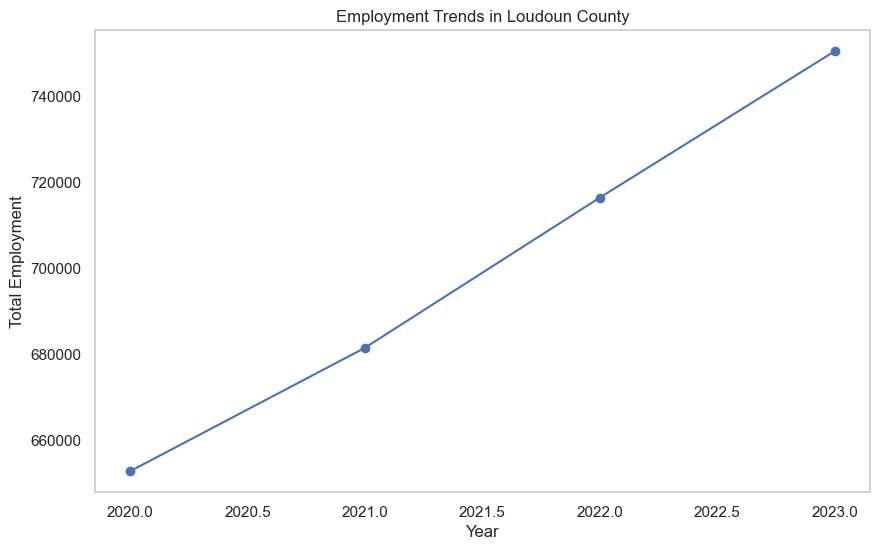

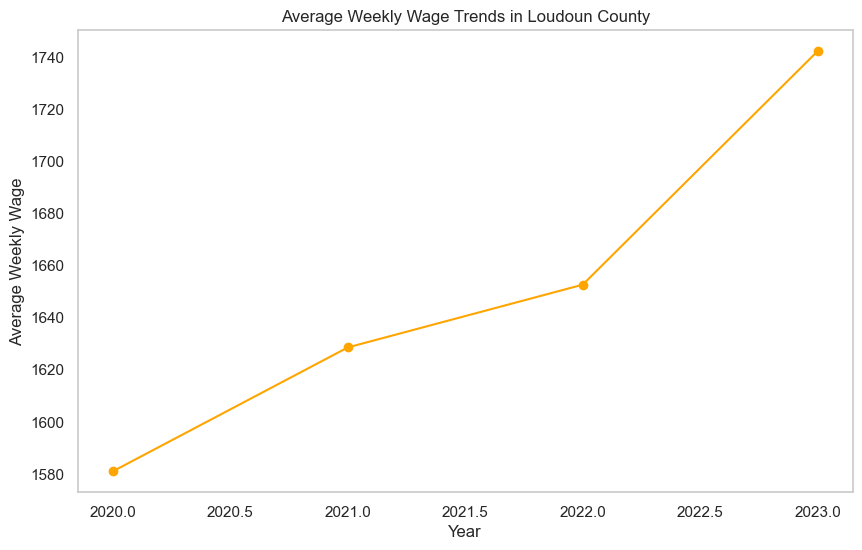

In [19]:
# Ensure that the required library is imported
import pandas as pd
import matplotlib.pyplot as plt

# Load the cleaned dataset from the preprocessed files
data_dir = r"C:\Users\AKKem\OneDrive\Desktop\Data Analysis Modules\Projects\Loudoun_Growth_Study\data"
bls_data_path = f"{data_dir}/Combined_BLS_Data.csv"

# Load the BLS dataset
bls_data = pd.read_csv(bls_data_path)

# Assign specific columns manually based on dataset inspection
geo_column = "area_fips"  # Replace with the column name indicating the geographic area (if "county" doesn't exist)
employment_column = "annual_avg_emplvl"  # Column for employment levels
wage_column = "annual_avg_wkly_wage"  # Column for weekly wages
year_column = "year"  # Column for the year

# Check if columns exist in the DataFrame
for col in [geo_column, employment_column, wage_column, year_column]:
    if col not in bls_data.columns:
        raise ValueError(f"Column '{col}' not found in the dataset.")

# Filter for Loudoun County (use the appropriate FIPS code or identifier)
loudoun_fips = 51107  # Replace with actual FIPS code for Loudoun County if available
loudoun_data = bls_data[bls_data[geo_column] == loudoun_fips]

# Ensure employment and wage columns are numeric
loudoun_data[employment_column] = pd.to_numeric(loudoun_data[employment_column], errors='coerce')
loudoun_data[wage_column] = pd.to_numeric(loudoun_data[wage_column], errors='coerce')

# Aggregate employment by year
employment_trends = loudoun_data.groupby(year_column)[employment_column].sum()

# Plot employment trends
plt.figure(figsize=(10, 6))
employment_trends.plot(kind="line", marker='o')
plt.title("Employment Trends in Loudoun County")
plt.xlabel("Year")
plt.ylabel("Total Employment")
plt.grid()
plt.show()

# Analyze average wages over time
average_wages = loudoun_data.groupby(year_column)[wage_column].mean()

# Plot wage trends
plt.figure(figsize=(10, 6))
average_wages.plot(kind="line", color="orange", marker='o')
plt.title("Average Weekly Wage Trends in Loudoun County")
plt.xlabel("Year")
plt.ylabel("Average Weekly Wage")
plt.grid()
plt.show()


C:\Users\AKKem\AppData\Local\Temp\ipykernel_32024\336694373.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loudoun_gdp[gdp_column] = pd.to_numeric(loudoun_gdp[gdp_column], errors='coerce')


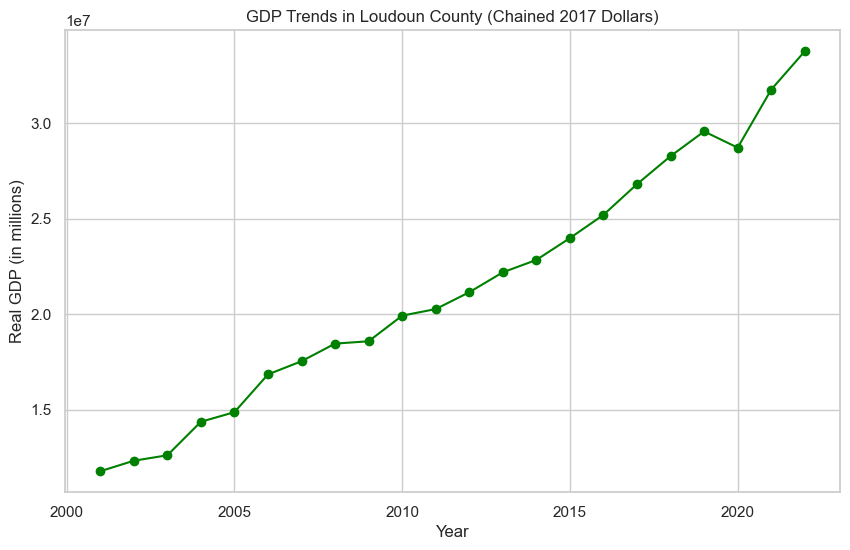

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset if not already loaded
file_path = r"C:\Users\AKKem\OneDrive\Desktop\Data Analysis Modules\Projects\Loudoun_Growth_Study\data\Combined_GDP_Data.csv"
gdp_data = pd.read_csv(file_path)

# Ensure all column names are lowercase
gdp_data.columns = gdp_data.columns.str.lower()

# Ensure the 'county_name' column is treated as strings
gdp_data["county name"] = gdp_data["county name"].astype(str)

# Filter the data for Loudoun County using the 'county_name' column
loudoun_gdp = gdp_data[gdp_data["county name"].str.contains("loudoun", na=False, case=False)]

# Ensure the GDP column is numeric and handle missing data if necessary
gdp_column = "real gdp (thousands of chained 2017 dollars)"
loudoun_gdp[gdp_column] = pd.to_numeric(loudoun_gdp[gdp_column], errors='coerce')

# Filter out rows with missing or zero GDP values
loudoun_gdp = loudoun_gdp.dropna(subset=[gdp_column])
loudoun_gdp = loudoun_gdp[loudoun_gdp[gdp_column] > 0]

# Plot GDP trends
plt.figure(figsize=(10, 6))
plt.plot(loudoun_gdp["year"], loudoun_gdp[gdp_column], marker='o', color="green")
plt.title("GDP Trends in Loudoun County (Chained 2017 Dollars)")
plt.xlabel("Year")
plt.ylabel("Real GDP (in millions)")
plt.grid(True)
plt.show()


Dataset Structure:
   Year Santa Clara County, California Montgomery County, Maryland  \
0  2010                         85,002                      89,155   
1  2015                        102,340                      98,917   
2  2020                        130,890                     111,812   
3  2023                        154,954                     125,371   

  Wake County, North Carolina Davidson County, Tennessee Dallas County, Texas  \
0                      61,426                     43,616               46,860   
1                      70,533                     52,026               51,799   
2                      83,567                     62,515               61,870   
3                     102,918                     80,379               74,350   

  Fairfax County, Virginia Loudoun County, Virginia  
0                  103,010                  119,540  
1                  113,208                  125,003  
2                  127,866                  147,111  
3       

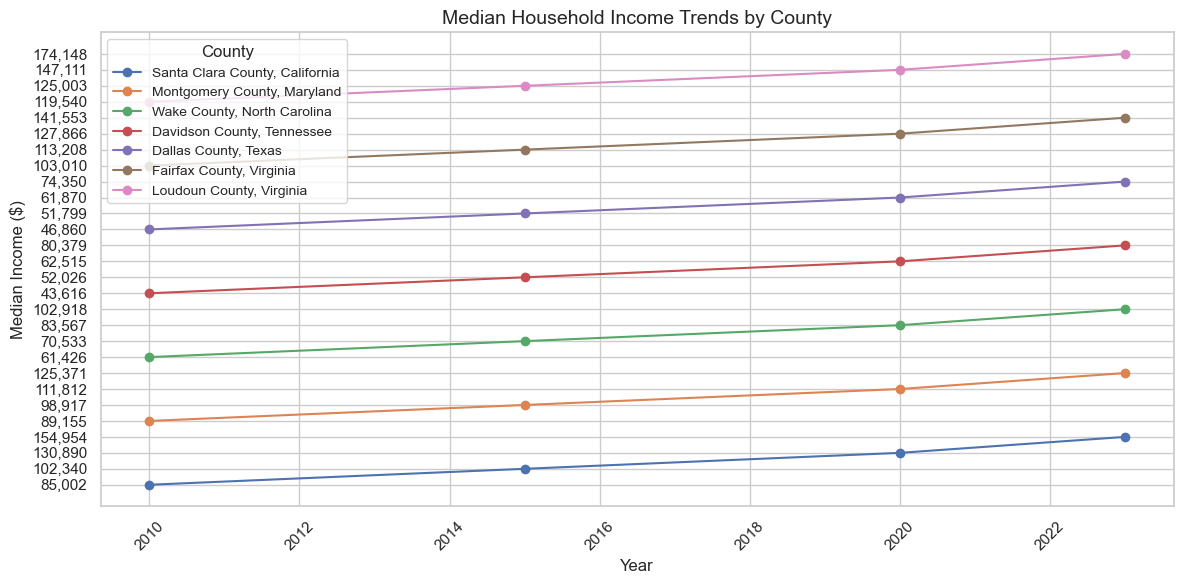

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Load the data
file_path = r"C:\Users\AKKem\OneDrive\Desktop\Data Analysis Modules\Projects\Loudoun_Growth_Study\data\Combined_B19013.csv"
income_data = pd.read_csv(file_path)

# Step 2: Inspect the dataset structure
print("Dataset Structure:")
print(income_data.head())

# Step 3: Transform (melt) the data from wide to long format
income_data_long = income_data.melt(
    id_vars=["Year"],  # Assuming "Year" is the column with years
    var_name="County",
    value_name="Median_Income"
)

# Step 4: Filter the data for selected counties
selected_counties = [
    "Santa Clara County, California",
    "Montgomery County, Maryland",
    "Wake County, North Carolina",
    "Davidson County, Tennessee",
    "Dallas County, Texas",
    "Fairfax County, Virginia",
    "Loudoun County, Virginia"
]
filtered_data = income_data_long[income_data_long["County"].isin(selected_counties)]

# Step 5: Plot the median household income trends
plt.figure(figsize=(12, 6))
for county in selected_counties:
    county_data = filtered_data[filtered_data["County"] == county]
    plt.plot(
        county_data["Year"],
        county_data["Median_Income"],
        marker='o',
        label=county
    )

plt.title("Median Household Income Trends by County", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Median Income ($)", fontsize=12)
plt.legend(title="County", fontsize=10)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

